## Baseball Annual All Star Game Analysis


### Import libraries

In [ ]:
import requests
from bs4 import BeautifulSoup
import re

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import arviz

import pystan

### Data collecting

This site (https://npb.jp/) has collected the all star game results from 1950. The result data was extracted for the analysis.

In [ ]:
url = 'https://npb.jp/bis/scores/allstargame/yearlyresults'
url_list =[url + str(i) + '.html' for i in range(1950, 2020, 10)]

In [ ]:
url_list

['https://npb.jp/bis/scores/allstargame/yearlyresults1950.html',
 'https://npb.jp/bis/scores/allstargame/yearlyresults1960.html',
 'https://npb.jp/bis/scores/allstargame/yearlyresults1970.html',
 'https://npb.jp/bis/scores/allstargame/yearlyresults1980.html',
 'https://npb.jp/bis/scores/allstargame/yearlyresults1990.html',
 'https://npb.jp/bis/scores/allstargame/yearlyresults2000.html',
 'https://npb.jp/bis/scores/allstargame/yearlyresults2010.html']

When the central league won, the data would be 1, when they lost, the data would be 0.

In [ ]:
win_data_comp = {}
start_year = 1951
for i in url_list:
  r = requests.get(i)
  soup = BeautifulSoup(r.content, 'html.parser')
  win_data_temp = soup.select('.allstarWin')

  for wdti in range(0, len(win_data_temp), 2):
    if int(re.sub("\\D", "", win_data_temp[wdti].get_text())) > int(re.sub("\\D", "", win_data_temp[wdti + 1].get_text())):
      win_data_comp[start_year] = 1
    elif int(re.sub("\\D", "", win_data_temp[wdti].get_text())) < int(re.sub("\\D", "", win_data_temp[wdti + 1].get_text())):
      win_data_comp[start_year] = 0
    else:
      win_data_comp[start_year] = None

    start_year += 1

In [ ]:
win_data_comp

{1951: 1,
 1952: 0,
 1953: 0,
 1954: 0,
 1955: None,
 1956: None,
 1957: None,
 1958: None,
 1959: None,
 1960: 0,
 1961: 0,
 1962: 0,
 1963: 1,
 1964: 1,
 1965: 0,
 1966: 0,
 1967: 0,
 1968: 1,
 1969: 0,
 1970: 1,
 1971: 0,
 1972: 0,
 1973: 0,
 1974: 0,
 1975: 1,
 1976: 0,
 1977: 1,
 1978: 1,
 1979: 1,
 1980: 1,
 1981: 1,
 1982: None,
 1983: 0,
 1984: 0,
 1985: 1,
 1986: 0,
 1987: 0,
 1988: 1,
 1989: None,
 1990: 0,
 1991: 1,
 1992: 1,
 1993: None,
 1994: None,
 1995: 1,
 1996: 0,
 1997: None,
 1998: 1,
 1999: 1,
 2000: 1,
 2001: 0,
 2002: None,
 2003: 1,
 2004: 0,
 2005: 1,
 2006: 1,
 2007: 1,
 2008: None,
 2009: None,
 2010: 1,
 2011: 0,
 2012: 1,
 2013: None,
 2014: None,
 2015: 1,
 2016: 1,
 2017: 0,
 2018: 0,
 2019: None}

In [ ]:
df = pd.DataFrame(list(win_data_comp.items()), columns=['year', 'win'])

In [ ]:
df

,year,win
0,1951,1.0
1,1952,0.0
2,1953,0.0
3,1954,0.0
4,1955,NaN
...,...,...
64,2015,1.0
65,2016,1.0
66,2017,0.0
67,2018,0.0


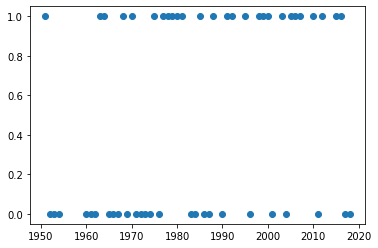

In [ ]:
plt.scatter(df['year'], df['win']);

In [ ]:
df['win'].dropna().mean()

0.5094339622641509

The mean of the data is 0.509 which seems both team have almost the same win rates. The win rate should fluctuate along the time.

The data is 1 or 0. The data is considered to be created from Bernoulli distribution. There are also some NaN in the data. I decided to use a state-space model to analyze the win rate along the time because the model can interpolate the lack of time series data and estimate the generative process of the data.

In [ ]:
df['id'] = [i for i in range(1, df.shape[0] + 1)]

In [ ]:
df

,year,win,id
0,1951,1.0,1
1,1952,0.0,2
2,1953,0.0,3
3,1954,0.0,4
4,1955,NaN,5
...,...,...,...
64,2015,1.0,65
65,2016,1.0,66
66,2017,0.0,67
67,2018,0.0,68


In [ ]:
df

,year,win,id
0,1951,1.0,1
1,1952,0.0,2
2,1953,0.0,3
3,1954,0.0,4
4,1955,NaN,5
...,...,...,...
64,2015,1.0,65
65,2016,1.0,66
66,2017,0.0,67
67,2018,0.0,68


## Model
It was assumed that the data was created from the local trend model below. The top one is the state equation, the bottom one is the observation equation.
$$
    \mu_t \sim Normal(\mu_{t-1} , \sigma^2)\\
    \\
    y_t \sim Bernoulli(logistic(\mu_t))
$$


In [ ]:
model = '''
data {
  int T;               // The length of the data
  int len_obs;         // The number of the observation
  int y[len_obs];      // The observation
  int obs_no[len_obs]; // The time series points that the observations could be gotten 
}

parameters {
  vector[T] mu;       // Estimated values of the state
  real<lower=0> s_w;  //　error
}

model {
  // Prior
  s_w ~ student_t(3, 0, 10);
  
  // State transition based on the state equation
  for(i in 2:T) {
    mu[i] ~ normal(mu[i-1], s_w);
  }
  
  // The observation
  for(i in 1:len_obs) {
    y[i] ~ bernoulli_logit(mu[obs_no[i]]);
  }
}

generated quantities{
  vector[T] probs;       // The estimated win rates
  
  probs = inv_logit(mu);
}
'''

In [ ]:
data = {
    'T': df.shape[0],
    'len_obs': df.dropna().shape[0],
    'y': df.dropna()['win'].apply(lambda x: int(x)),
    'obs_no': df.dropna()['id']
}

In [ ]:
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3c3ab525416b20389b3b30645bf1977a NOW.


In [ ]:
fit = sm.sampling(data=data, seed = 1, chains=4, iter = 6000, warmup = 1000, thin = 20, control = dict(adapt_delta = 0.9, max_treedepth = 15))

In [ ]:
print(fit)

Inference for Stan model: anon_model_3c3ab525416b20389b3b30645bf1977a.
4 chains, each with iter=6000; warmup=1000; thin=20; 
post-warmup draws per chain=250, total post-warmup draws=1000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]       -0.67    0.04   1.04  -2.66  -1.26  -0.56  -0.11   0.99    550    1.0
mu[2]       -0.86    0.05   1.02  -3.02  -1.35  -0.69  -0.21   0.63    367   1.02
mu[3]       -0.97     0.1   1.39  -3.46  -1.45  -0.75  -0.24   0.56    202   1.03
mu[4]        -1.0     0.1   1.36  -3.71  -1.47  -0.77  -0.24   0.53    191   1.03
mu[5]       -0.95    0.08   1.29  -3.42  -1.43  -0.74  -0.23   0.51    281   1.02
mu[6]       -0.94    0.08   1.35  -3.72  -1.39  -0.73  -0.21   0.59    264   1.02
mu[7]       -0.93    0.08   1.32  -3.55  -1.38  -0.71  -0.21    0.5    263   1.02
mu[8]       -0.91    0.06   1.48  -3.51  -1.39  -0.68  -0.17   0.54    690   1.01
mu[9]        -0.9    0.07   1.16  -3.46  -1.35  -0.68  -0.21   0.55    28

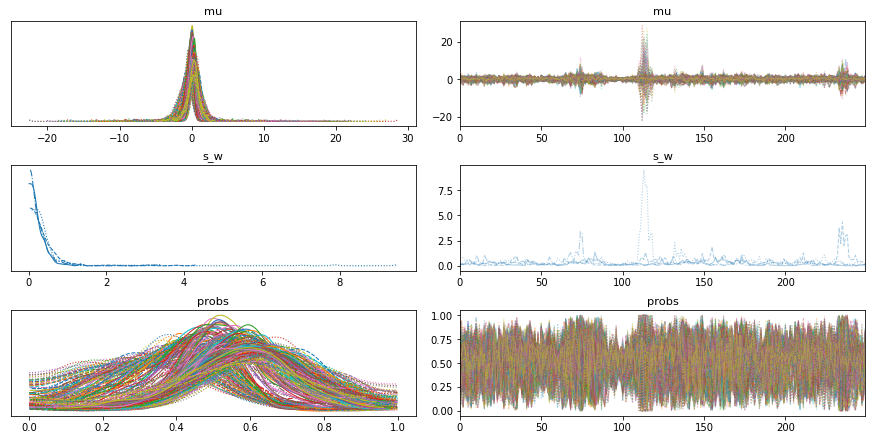

In [ ]:
arviz.plot_trace(fit)
plt.show()

In [ ]:
results = fit.extract()

In [ ]:
len(results['probs'][0])

69

In [ ]:
probs_array = np.array(results['probs'])

In [ ]:
probs_array

array([[0.19424406, 0.22251274, 0.196938  , ..., 0.4412008 , 0.48113782,
        0.55926166],
       [0.40089747, 0.48216228, 0.37604183, ..., 0.32531355, 0.25382014,
        0.24024821],
       [0.44224398, 0.43110337, 0.41291984, ..., 0.35089551, 0.36052349,
        0.36194123],
       ...,
       [0.2647184 , 0.17864319, 0.1814795 , ..., 0.81133032, 0.76394973,
        0.82443005],
       [0.74675552, 0.27961701, 0.52161913, ..., 0.28587318, 0.19984241,
        0.07299685],
       [0.72879907, 0.57416597, 0.49312345, ..., 0.48903376, 0.21605578,
        0.14852985]])

In [ ]:
probs_results = np.array(np.average(probs_array, axis=0))

In [ ]:
probs_results

array([0.35969939, 0.33212516, 0.32097379, 0.31756623, 0.32113638,
       0.32650742, 0.32566702, 0.32963699, 0.32908829, 0.3274423 ,
       0.33499935, 0.352482  , 0.38740793, 0.39095909, 0.37061725,
       0.36853371, 0.37624317, 0.40277042, 0.39572921, 0.41535765,
       0.40153822, 0.39904947, 0.408415  , 0.43295018, 0.47842726,
       0.48965947, 0.53336499, 0.5576783 , 0.56841461, 0.57108777,
       0.56356442, 0.53999194, 0.51275491, 0.50620082, 0.51908045,
       0.51020339, 0.5164265 , 0.54758248, 0.55273066, 0.5644114 ,
       0.59831113, 0.61029456, 0.60965838, 0.61042349, 0.61794222,
       0.60663409, 0.62417426, 0.6418552 , 0.64892647, 0.64406532,
       0.62315371, 0.63268211, 0.64067412, 0.62897942, 0.65431625,
       0.66261026, 0.66185127, 0.65516137, 0.65280277, 0.6443005 ,
       0.62554918, 0.63106707, 0.6213845 , 0.61831238, 0.61287118,
       0.59656485, 0.55551438, 0.53731959, 0.54064241])

In [ ]:
probs_025 = np.array(np.percentile(probs_array, 2.5, axis=0))
probs_975 = np.array(np.percentile(probs_array, 97.5, axis=0))

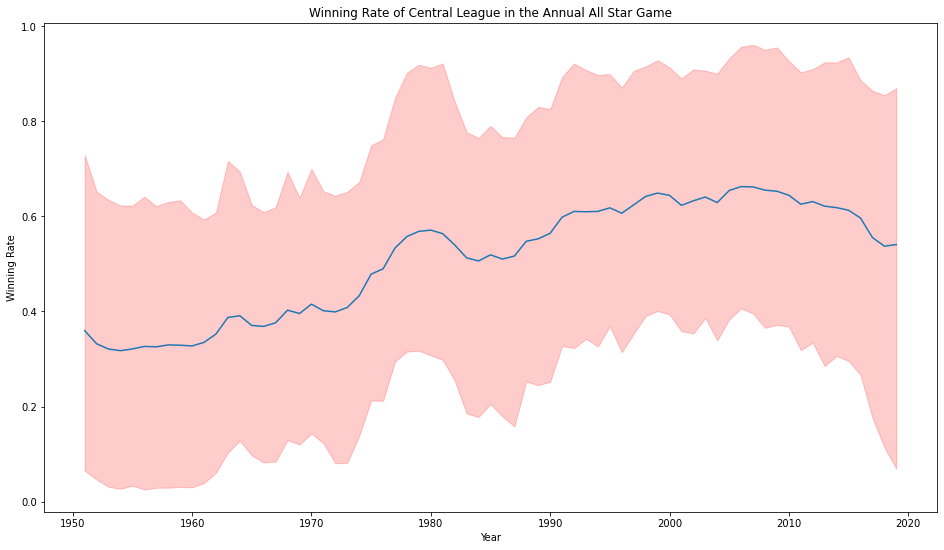

In [ ]:
plt.figure(figsize=(16,9));
plt.plot(df['year'], probs_results);
plt.fill_between(df['year'], probs_025, probs_975, color='red', alpha=0.2);
plt.xlabel('Year');
plt.ylabel('Winning Rate');
plt.title('Winning Rate of Central League in the Annual All Star Game');

The result shows that the win rate fluctuated along the time. In 1950 to 1970, the central league win rates were around 0.4. The rate went back to 0.5 in around 1980. The central league win rate went up to about 0.6 in 2000 to 2010. After 2010, the rate has been getting down to 0.5. 

It will be interesting to investigate the players stats and see the stats and the win rate in this analysis.